# To run this code

### 0. Move to Google Colab by pressing this link  

### 1. Setting GPU in notebook setting (refer to below image)
 - ① Click "Runtime" in menu
 - ② Click "Change runtime type"
 - ③ Set Hardware accelerator as "GPU" 
 - ④ Click "Save"
 

### 2. Run the code (Keep pressing "Shift + Enter" key until the end of the code blocks)
- If a warning message appeared, just click "Run anyway"
- There are 4 session in this codes;
- "1.Load library"
- "2.Load pretrained model"
- "3.Prepare test dataset"
- "4.Inference result"

### 3. If you have additional image to diagnosis (refer to below image)
- ① Click folder button on the bottom of left sidebar
- ② Click "FootDiagnosis" to expand the tree structure
- ③ Drag and drop your foot X-ray images to "FootDiagnosis/input_data"
- ④ Run the code from "3.Prepare test dataset" (By using "Shift + Enter")



## 1. Loading library

In [1]:
!git clone https://github.com/SoyoungLee8/TLspine_FxLevel_Segmentation.git
%cd TLspine_FxLevel_Segmentation/

!pip install -U pydicom nibabel monai==0.8.0 kornia pytorch_lightning
!pip install --upgrade https://github.com/VincentStimper/mclahe/archive/numpy.zip
!pip install --upgrade gdown
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Cloning into 'TLspine_FxLevel_Segmentation'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 16 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), 1.37 MiB | 14.43 MiB/s, done.


In [ ]:
# load pretrained model
import monai
import lightening_segmenter
import model_multitask
import torchmetrics
# prepare test dataset
import natsort
import glob
import os
import dataset
import torch
from torch.utils.data import DataLoader
import numpy as np
import cv2
import albumentations as albu
import mclahe
import matplotlib.pyplot as plt
# inference result
from scipy.ndimage import label
import postprocessing as post

## 2. Load pretrained model

In [4]:
# define loss and metric function
lossfn = monai.losses.DiceFocalLoss(to_onehot_y=True)
metricfn = torchmetrics.functional.dice

# model
experiment_name = 'U2NET'
net = model_multitask.Unet()
model = lightening_segmenter.Segmentor(network=net, lossfn=lossfn, metricfn=metricfn, experiment_name=experiment_name,)

# load pretrained weight
!gdown https://drive.google.com/uc?id=1wgl5iDbpmPbIdQDCoQMwJXPs6m2jBI7e -O epoch=16-step=7938.ckpt
model.load_from_checkpoint(network=net, lossfn=lossfn, metricfn=metricfn, experiment_name=experiment_name,checkpoint_path='epoch=16-step=7938.ckpt')
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 72.6MB/s]


# 3. Prepare test dataset

- Load files from "./TLspine_FxLevel_Segmentation/test_data/" folder
- All datas get google search
- If you have L-spine lateral X-ray to analyze, upload file to "test_data" (.png, .jpg, .tif)

In [7]:
x_etest = natsort.natsorted(glob.glob(os.path.join('test_data','*')))
print(x_etest)

albu_transform = [
                # albu.Normalize(mean= 3028.37, std = 1720.31, max_pixel_value=1.0),
                albu.LongestMaxSize(max_size=1024, interpolation=cv2.INTER_CUBIC, p=1), 
                albu.PadIfNeeded(border_mode=cv2.BORDER_CONSTANT, min_height=1024, min_width=1024, p=1)
            ]
            
transforms = albu.Compose(albu_transform)

class test_dataset() : 
    def __init__(self, data) :
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        fname = self.data[idx]
        image = cv2.imread(fname)
        # outlier clip
        x_cutoff_max = int(np.percentile(image, 99))
        image_clip = image.clip(0, x_cutoff_max)
        # normalization, resize
        sample = transforms(image=image_clip)
        image_transform = sample['image']
        # clahe
        image_clahe = dataset.clahe(image_transform.astype(np.float32),True)
        image_clahe = np.moveaxis(image_clahe,-1,0)
        image_clahe = torch.tensor(image_clahe)

        return {'image':image_clahe, 'fname':fname}

etest_ds = test_dataset(data=x_etest)
etest_loader = DataLoader(etest_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

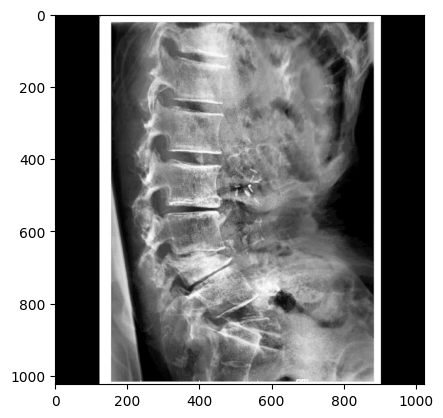

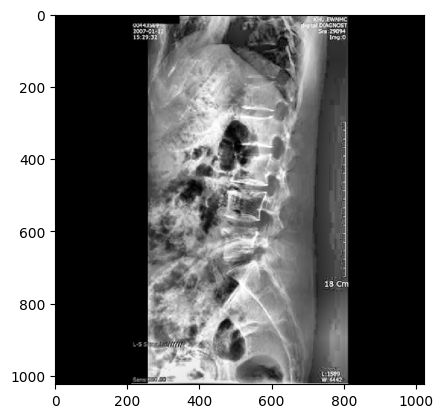

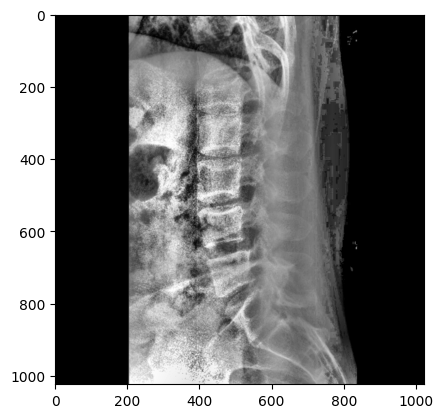

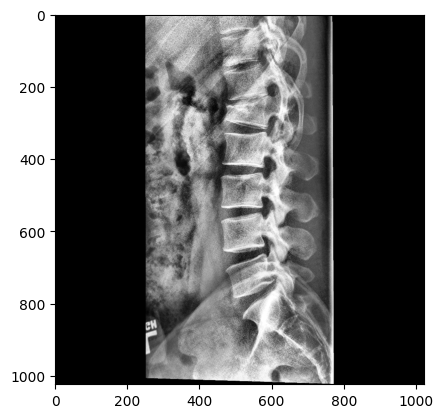

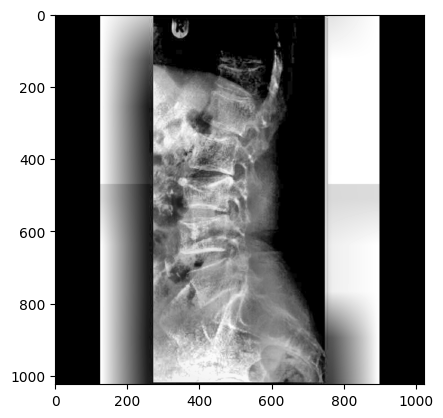

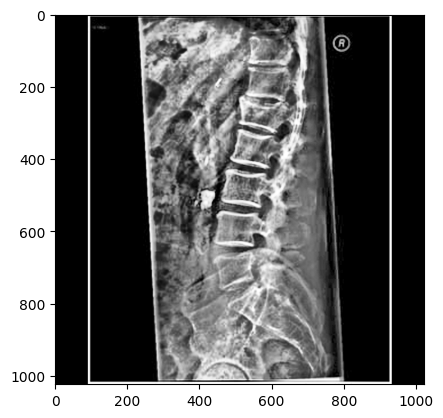

In [9]:
# check
for i in range(6):
    plt.imshow(etest_ds[i]['image'][0], cmap='gray')
    plt.show()

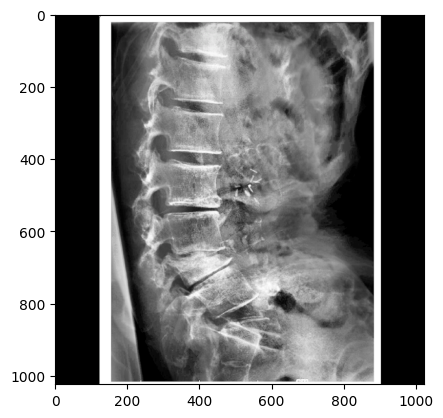

In [89]:
# # testset sample show
iterator = iter(etest_loader)
batch = next(iterator)
############################# DEPEND ON DATASET #################################
image, fname = batch['image'], batch['fname']
#################################################################################
for idx in range(len(image)):
    print(fname[idx])
    plt.imshow(image[idx].permute(1,2,0), cmap='gray')
    plt.show()


# 4. Inference result

In [10]:
# helper function for data visualization
def plot_(img, alpha):    
    try:
        plt.imshow(img.cpu().detach().numpy(), cmap='gray', alpha=alpha)
    except:
        plt.imshow(img,cmap='gray',alpha=alpha)

def plot_color(img, alpha):
    try:
        plt.imshow((img.cpu().detach().numpy())/3, cmap='bone', alpha=alpha) # bone, afmhat 
    except:
        plt.imshow(img/3,cmap='bone',alpha=alpha)
        
def visualize(fname=None,**images):
    """Plot images in one row."""
    
    n = len(images)
    # plt.figure(figsize=(26, 12))
    plt.figure(figsize=(52, 24))
    
    for i, (name, image) in enumerate(images.items()):
        if torch.is_tensor(image) and image.shape[0] == 3:
            image = image.permute(1,2,0)#.int()
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), fontsize=35)
        if i == 0:
            image_ori = image
            plot_(image_ori,1)
        else:
            plot_(image_ori,1)
            plot_color(image,0.7)
    plt.show()

In [13]:
def refine_position(batch_yhat):
    """
    batch_yhat : B x C x H x W only after softmax
    result : B x 1 x H x W
    index : 0, 1(L), 2(T), 3(S)
    """
    batch_yhat = torch.argmax(batch_yhat,1).unsqueeze(1) # B x 1 x H x W
    batch_yhat_1 = batch_yhat.clone()
    batch_yhat_1[batch_yhat_1!=0] = 1
    result = np.zeros_like(batch_yhat_1.cpu().detach().numpy())
    # result = np.zeros_like(batch_yhat_1.cpu().detach().numpy())
    kernel = np.ones((5,5), np.uint8)
    for i in range(len(batch_yhat_1)):
        batch_yhat_2 = cv2.morphologyEx((batch_yhat_1[i,0].cpu().detach().numpy()).astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=5)
        spines, _ = label(batch_yhat_2)
        for j in range(1, len(np.unique(spines))): # 0(=background) 빼고 iter
            spine = spines.copy()
            # body 1개만 1로 만들기
            spine[spine!=j] = 0
            spine[spine!=0] = 1
            unique, counts = np.unique(spine*batch_yhat[i,0].cpu().detach().numpy(),return_counts=True)
            if 3 in unique:
                idx = list(unique).index(3)
                if counts[idx]/np.sum(counts[1:]) >= 0.3:
                    spine = spine*3
                else:
                    spine = spine*batch_yhat[i,0].cpu().detach().numpy()
            elif 1 in unique:
                idx = list(unique).index(1)
                if counts[idx]/np.sum(counts[1:]) >= 0.3:
                    spine = spine*1 # L spine
                else:
                    spine = spine*2 # T spine
            elif 2 in unique:
                spine = spine*2
            result[i,0] += spine
        result[i,0] = refine5L(result[i,0])
    return result

def refine5L(result):
    '''
    input : H x W
    output : H x W
    When the number of L spine segment is 4: last segment of T spine convert L spine
    When the number of L spine segment is 6: first segment of L spine convert T spine
    '''
    sacrum = result.copy()
    sacrum[sacrum!=3] = 0
    
    Tspine = result.copy()
    Tspine[Tspine!=2] = 0
    
    Lspine = result.copy()
    Lspine[Lspine!=1] = 0
    
    lspines, _ = label(Lspine)
    if len(np.unique(lspines)) == 6:
        pass
    elif len(np.unique(lspines)) < 6:
        print('add L1')
        tspines, _ = label(Tspine)
        iter_num = 6 - len(np.unique(lspines))
        for i in range(iter_num):
            i += 1 # i = 1,2,3...
            i = (-1)*i # i = -1,-2,-3...
            L1 = np.unique(tspines)[i]
            Tspine[tspines==L1] = 1
    elif len(np.unique(lspines)) > 6:
        print('del T12')
        iter_num = len(np.unique(lspines)) - 6
        for i in range(iter_num):
            i += 1 # i = 1,2,3
            Lspine[lspines==i] = 2
    output = Tspine + Lspine + sacrum
    
    return output

def refine_fracture(batch_yhat, threshold=.3):
    """
    batch_yhat : only after softmax
    """
    batch_yhat = torch.argmax(batch_yhat,1).unsqueeze(1) # B x 1 x H x W
    batch_yhat_1 = batch_yhat.clone()
    batch_yhat_1[batch_yhat_1!=0] = 1
    result = np.zeros_like(batch_yhat_1.cpu().detach().numpy())
    
    # each batch
    kernel = np.ones((5,5), np.uint8)
    for i in range(len(batch_yhat_1)):
        batch_yhat_2 = cv2.morphologyEx((batch_yhat_1[i,0].cpu().detach().numpy()).astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=5)
        spines, _ = label(batch_yhat_2)
        for j in range(1, len(np.unique(spines))): # except 0(=background)
            spine = spines.copy()
            spine[spine!=j] = 0
            spine[spine!=0] = 1
            unique, counts = np.unique(spine*batch_yhat[i,0].cpu().detach().numpy(),return_counts=True)
            if 2 in unique:
                idx = list(unique).index(2)
                if counts[idx]/np.sum(counts[1:]) >= threshold:
                    spine = spine*2
            else:
                spine = spine*batch_yhat[i,0].cpu().detach().numpy()
            result[i,0] += spine
    return result

In [ ]:
for idx, batch in enumerate(etest_loader) : 
    x = batch['image']
    fname = batch['fname']
    yhat = model(x.cuda())
    yhat_position = post.refine_position(yhat[1])
    yhat_fracture = post.refine_fracture(yhat[0])
    for idx in range(len(x)):
        print(f'the below image is {fname[idx]}')
        visualize(fname=fname[idx], input_image=x[idx,0], fx_refine=yhat_fracture[idx,0], level_refine=yhat_position[idx,0])
